# Import Packages and Dataset

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

In [3]:
# import breast cancer dataset for binary classification
x,y = load_breast_cancer(return_X_y=True)
dim_x = x.shape[1]

# Utilities

In [4]:
tf_float_type = tf.float64
np_float_type = np.float64
as_tf_float = lambda x: tf.cast(x, tf_float_type)

In [5]:
def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

# Logistic Regression on Dataset

In [6]:
m = LogisticRegression(max_iter=10000).fit(x,y)
m.coef_

array([[ 1.02743284,  0.18106721, -0.2734324 ,  0.02231185, -0.18160364,
        -0.22197946, -0.54139022, -0.30176878, -0.27041253, -0.02992543,
        -0.08151345,  1.25273389,  0.09216139, -0.10652557, -0.02567079,
         0.07200057, -0.0321638 , -0.03869664, -0.03672253,  0.01478789,
         0.12643447, -0.43542492, -0.1012318 , -0.01378675, -0.36257047,
        -0.68317936, -1.42725958, -0.61444911, -0.74060591, -0.09397159]])

In [7]:
m.score(x,y)

0.9578207381370826

# Bayesian Logistic Regression on dataset

## Variatioal Bayes by KL[q||p]

In [8]:
def pointwise_ELBO(loc_beta, scale_beta, beta):
    """
    Compute ELBO for n_MC samples of beta, where the shape of beta is [n_MC, dim_x].
    
    Arguments:
    loc_beta: 1-d array of size [dim_x]
    scale_beta: 1-d array of size [dim_x]
    beta: 2-d array of size [n_MC, dim_x] representing the n_MC samples of beta taken from q_beta
    
    Returns:
    elbo: n_MC MC-samples of elbo
    """
    p_beta = tfp.distributions.Normal(loc=np.zeros([dim_x]), scale=np.ones([dim_x]))
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    z = beta @ x.T# of shape [n_MC, n_train]
    p_y = tfd.Bernoulli(logits=z)
    y_ = y.reshape([1, -1])
    elbo = tf.reduce_sum( p_y.log_prob(y_), axis=1)\
            + tf.reduce_sum( p_beta.log_prob(beta), axis=1)\
            - tf.reduce_sum( q_beta.log_prob(beta), axis=1)
    return elbo

In [9]:
def ELBO(loc_beta, scale_beta, n_MC=1):
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample(n_MC)# of shape [n_MC, dim_x]
    elbo = tf.reduce_mean( pointwise_ELBO(loc_beta, scale_beta, beta) )
    return elbo

In [10]:
loc = tf.Variable(np.zeros([dim_x]))
invSPscale = tf.Variable(np.ones([dim_x])) # defined as inv_softplus(scale) to keep the positive constraint of scale
    
for t in range(4000):
    rho_t = 5e-6/(10+t)**0.7
    
    with tf.GradientTape() as g:
        g.watch([loc, invSPscale])
        scale = tf.math.softplus(invSPscale) 
        score = ELBO(loc, scale, 100)
    dloc, dinvSPscale = g.gradient(score, [loc, invSPscale])

    loc = loc + rho_t*dloc
    invSPscale = invSPscale + rho_t*dinvSPscale
print(score)

tf.Tensor(-21087.871548940027, shape=(), dtype=float64)


In [11]:
loc

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 1.18614511e-01,  2.19474852e-01,  7.24304508e-01,  9.50990080e-01,
        1.23877964e-03,  3.84078417e-04, -7.28906150e-04, -3.67350539e-04,
        2.34037957e-03,  9.26860835e-04,  6.75937878e-04,  1.73595398e-02,
        3.58544653e-03, -2.46351425e-01,  1.06205200e-04,  1.65225184e-04,
        1.62925466e-04,  7.59804435e-05,  2.90049026e-04,  4.64980009e-05,
        1.13885264e-01,  2.80227607e-01,  6.90804311e-01, -9.17959652e-01,
        1.62106894e-03,  4.17846498e-04, -9.51687636e-04, -1.59868074e-04,
        3.38235394e-03,  1.02956243e-03])>

In [12]:
scale

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1.29517033, 1.27114864, 0.80945935, 0.10263139, 1.31320424,
       1.31321577, 1.31320426, 1.31320503, 1.31320853, 1.31321129,
       1.31316065, 1.31294971, 1.31227143, 1.16356333, 1.31321075,
       1.31321218, 1.3132122 , 1.31321115, 1.31321132, 1.31321171,
       1.28909647, 1.24213144, 0.72407431, 0.07640721, 1.31321164,
       1.31319891, 1.31320773, 1.31321931, 1.31320651, 1.31320305])>

In [13]:
np.mean((x @ loc.numpy()>0)==y) # accuracy of binary prediction

0.9068541300527241

## Variational Bayes by Renyi Divergence

In [14]:
def KL_term(loc_beta, scale_beta, n_MC=1):
    p_beta = tfp.distributions.Normal(loc=np.zeros([dim_x]), scale=np.ones([dim_x]))
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample(n_MC)# of shape [n_MC, dim_x]
    z = tf.matmul(beta, x.T)# of shape [n_MC, n_train]
    p_y = tfd.Bernoulli(logits=z)
    y_ = y.reshape([1, -1])
    pointwise_KL = tf.reduce_sum( p_beta.log_prob(beta), axis=1)\
                    - tf.reduce_sum( q_beta.log_prob(beta), axis=1)
    return tf.reduce_mean(pointwise_KL)

In [15]:
KL_term(loc, scale, 100)

<tf.Tensor: shape=(), dtype=float64, numpy=-7.769432408652717>

In [16]:
def pointwise_IWELBO(loc_beta, scale_beta, beta):
    """
    Compute ELBO for n_MC samples of beta, where the shape of beta is [n_MC, dim_x].
    
    Arguments:
    loc_beta: 1-d array of size [dim_x]
    scale_beta: 1-d array of size [dim_x]
    beta: 3-d array of size [n_MC_out, n_MC_in, dim_x] representing the n_MC samples of beta taken from q_beta
    
    Returns:
    elbo: n_MC MC-samples of elbo
    """

    p_beta = tfp.distributions.Normal(loc=np.zeros([dim_x]), scale=np.ones([dim_x]))
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    z = beta @ x.T# of shape [n_MC_out, n_MC_in, n_train]
    p_y = tfd.Bernoulli(logits=z)
    log_prob_ratio = tf.reduce_sum( p_y.log_prob(y), axis=2)\
                    + tf.reduce_sum( p_beta.log_prob(beta), axis=2)\
                    - tf.reduce_sum( q_beta.log_prob(beta), axis=2)# of shape [n_MC_out, n_MC_in]
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=1)
    return iwelbo

In [17]:
def IWELBO(loc_beta, scale_beta, n_MC_out=1, n_MC_in=1):
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample([n_MC_out, n_MC_in])# of shape [n_MC_out, n_MC_in, dim_x]
    iwelbo = tf.reduce_mean( pointwise_IWELBO(loc_beta, scale_beta, beta) )
    return iwelbo

In [18]:
IWELBO(loc, scale, n_MC_out=100, n_MC_in=1)

<tf.Tensor: shape=(), dtype=float64, numpy=-16336.587319149776>

In [19]:
ELBO(loc, scale, n_MC=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-19657.90617668756>

In [20]:
def pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma):
    """
    Compute ELBO for n_MC samples of beta, where the shape of beta is [n_MC, dim_x].
    
    Arguments:
    loc_beta: 1-d array of size [dim_x]
    scale_beta: 1-d array of size [dim_x]
    beta: 3-d array of size [n_MC_out, n_MC_in, dim_x] representing the n_MC samples of beta taken from q_beta
    
    Returns:
    elbo: n_MC MC-samples of elbo
    """

    p_beta = tfp.distributions.Normal(loc=np.zeros([dim_x]), scale=np.ones([dim_x]))
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    z = beta @ x.T# of shape [n_MC_out, n_MC_in, n_train]
    p_y = tfd.Bernoulli(logits=z)
    log_prob_ratio = tf.reduce_sum( p_y.log_prob(y), axis=2)\
                    + tf.reduce_sum( p_beta.log_prob(beta), axis=2)\
                    - tf.reduce_sum( q_beta.log_prob(beta), axis=2)# of shape [n_MC_out, n_MC_in]
    score = 1./gamma * tf_logmeanexp(gamma * log_prob_ratio, axis=1)
    return score

In [21]:
def Renyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=1, n_MC_in=1):
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample([n_MC_out, n_MC_in])# of shape [n_MC_out, n_MC_in, dim_x]
    score = tf.reduce_mean( pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma) )
    return score

In [22]:
Renyi_Chi(loc, scale, gamma=1, n_MC_out=100, n_MC_in=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-1936.1934821923628>

In [23]:
IWELBO(loc, scale, n_MC_out=100, n_MC_in=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-1905.2577076402463>

In [24]:
Renyi_Chi(loc, scale, gamma=1./2, n_MC_out=100, n_MC_in=100)

<tf.Tensor: shape=(), dtype=float64, numpy=-1937.1951177488452>

In [25]:
loc = tf.Variable(np.zeros([dim_x]))
invSPscale = tf.Variable(np.ones([dim_x])) # defined as inv_softplus(scale) to keep the positive constraint of scale
    
for t in range(1000):
    rho_t = 1e-4/(10+t)**0.7
    
    with tf.GradientTape() as g:
        g.watch([loc, invSPscale])
        scale = tf.math.softplus(invSPscale) 
        score = Renyi_Chi(loc, scale, gamma=1./2, n_MC_out=100, n_MC_in=20)
    dloc, dinvSPscale = g.gradient(score, [loc, invSPscale])

    loc = loc + rho_t*dloc
    invSPscale = invSPscale + rho_t*dinvSPscale
print(score)

tf.Tensor(-1812.386259107549, shape=(), dtype=float64)


In [26]:
loc

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 2.19412505e-01,  2.40471042e-01,  1.22059265e+00,  3.03734080e-01,
        1.69849507e-03, -2.44603835e-03, -6.05670650e-03, -2.47086106e-03,
        3.29562010e-03,  1.43879480e-03,  1.53302510e-03,  1.75485893e-02,
       -1.13403092e-02, -5.81751472e-01,  8.09681877e-05, -6.59305597e-04,
       -9.30986260e-04, -1.76670772e-04,  2.16045528e-04, -1.57655599e-05,
        2.35073983e-01,  2.71659462e-01,  1.19681384e+00, -5.10950595e-01,
        1.87589753e-03, -9.39812204e-03, -1.48278659e-02, -3.63346585e-03,
        3.55395187e-03,  9.16426615e-04])>

In [27]:
scale

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1.31130282, 1.25132672, 1.15880874, 0.22322541, 1.31271033,
       1.31265101, 1.31263738, 1.31268055, 1.31255814, 1.3126714 ,
       1.31273162, 1.3123736 , 1.30716389, 0.99530731, 1.31267869,
       1.31268723, 1.31265222, 1.31266927, 1.31269361, 1.31267036,
       1.30852148, 1.18850286, 0.97892056, 0.1827517 , 1.31263726,
       1.31250039, 1.31278489, 1.31267229, 1.31282826, 1.31261277])>

In [28]:
np.mean((x @ loc.numpy()>0)==y) # accuracy of binary prediction

0.9191564147627417

In [29]:
loc

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 2.19412505e-01,  2.40471042e-01,  1.22059265e+00,  3.03734080e-01,
        1.69849507e-03, -2.44603835e-03, -6.05670650e-03, -2.47086106e-03,
        3.29562010e-03,  1.43879480e-03,  1.53302510e-03,  1.75485893e-02,
       -1.13403092e-02, -5.81751472e-01,  8.09681877e-05, -6.59305597e-04,
       -9.30986260e-04, -1.76670772e-04,  2.16045528e-04, -1.57655599e-05,
        2.35073983e-01,  2.71659462e-01,  1.19681384e+00, -5.10950595e-01,
        1.87589753e-03, -9.39812204e-03, -1.48278659e-02, -3.63346585e-03,
        3.55395187e-03,  9.16426615e-04])>

In [30]:
scale

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1.31130282, 1.25132672, 1.15880874, 0.22322541, 1.31271033,
       1.31265101, 1.31263738, 1.31268055, 1.31255814, 1.3126714 ,
       1.31273162, 1.3123736 , 1.30716389, 0.99530731, 1.31267869,
       1.31268723, 1.31265222, 1.31266927, 1.31269361, 1.31267036,
       1.30852148, 1.18850286, 0.97892056, 0.1827517 , 1.31263726,
       1.31250039, 1.31278489, 1.31267229, 1.31282826, 1.31261277])>

In [31]:
np.mean((x @ loc.numpy()>0)==y) # accuracy of binary prediction

0.9191564147627417

# MLMC codition check

In [32]:
def pointwise_dRenyi_Chi(loc_beta, scale_beta, gamma, beta):
    n_MC_in = beta.shape[1]
    assert np.log2(n_MC_in)%1==0
    if n_MC_in == 1:
        scores = pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma) 
    else:
        scores = pointwise_Renyi_Chi(loc_beta, scale_beta, beta, gamma)
        scores -= (1/2.) * pointwise_Renyi_Chi(loc_beta, scale_beta, beta[:,:n_MC_in//2 ,:], gamma)
        scores -= (1/2.) * pointwise_Renyi_Chi(loc_beta, scale_beta, beta[:, n_MC_in//2:,:], gamma)
    return scores

In [33]:
def dRenyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=1, level=1):
    n_MC_in = 2**level
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample([n_MC_out, n_MC_in])# of shape [n_MC_out, n_MC_in, dim_x]
    return tf.reduce_mean( pointwise_dRenyi_Chi(loc_beta, scale_beta, gamma, beta) )

In [34]:
def conv_stats_dRenyi_Chi(loc_beta, scale_beta, gamma, n_MC_out=10, level=1):
    n_MC_in = 2**level
    q_beta = tfp.distributions.Normal(loc=loc_beta, scale=scale_beta)
    beta = q_beta.sample([n_MC_out, n_MC_in])# of shape [n_MC_out, n_MC_in, dim_x]
    scores = pointwise_dRenyi_Chi(loc_beta, scale_beta, gamma, beta).numpy()
    mean = scores.mean()
    abs_mean = np.abs(mean)
    var = scores.var()
    return {'mean':mean, 'abs_mean':abs_mean, 'var':var}

In [40]:
conv_stats = [conv_stats_dRenyi_Chi(loc, scale, gamma=1, n_MC_out=10, level=level) for level in range(15)]
conv_stats = pd.DataFrame(conv_stats)

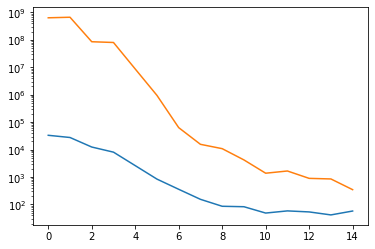

In [41]:
plt.plot(conv_stats[['abs_mean', 'var']])
plt.yscale('log')

In [42]:
conv_stats

,mean,abs_mean,var
0,-33217.793464,33217.793464,6.391500e+08
1,27622.412537,27622.412537,6.693445e+08
2,12408.656853,12408.656853,8.564797e+07
3,8072.069043,8072.069043,8.039011e+07
4,2605.125894,2605.125894,8.691902e+06
5,839.497488,839.497488,9.468311e+05
6,357.208856,357.208856,6.317665e+04
7,153.781957,153.781957,1.557447e+04
8,85.855964,85.855964,1.082130e+04
9,82.667540,82.667540,4.205092e+03
